In [1]:
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

D:\Anaconda\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map (num_proc=4): 100%|██████████████████████████████████| 2000/2000 [00:11<00:00, 172.21 examples/s]


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

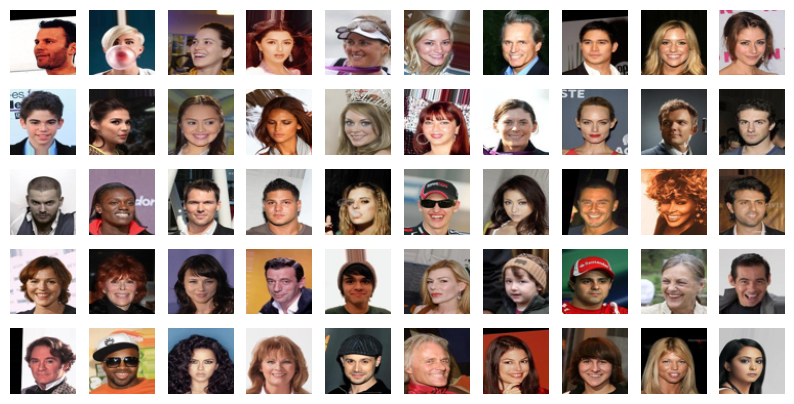

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
#这个block和auto encoders是完全一样的
class Block(torch.nn.Module):

    def __init__(self, dim_in, dim_out, is_encoder=True):
        super().__init__()

        cnn_type = torch.nn.Conv2d
        if not is_encoder:
            cnn_type = torch.nn.ConvTranspose2d

        def block(dim_in, dim_out, kernel_size=3, stride=1, padding=1):
            return (
                cnn_type(dim_in,
                         dim_out,
                         kernel_size=kernel_size,
                         stride=stride,
                         padding=padding),
                torch.nn.BatchNorm2d(dim_out),
                torch.nn.LeakyReLU(),
            )

        self.s = torch.nn.Sequential(
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_out, kernel_size=3, stride=2, padding=0),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
        )

        self.res = cnn_type(dim_in,
                            dim_out,
                            kernel_size=3,
                            stride=2,
                            padding=0)

    def forward(self, x):
        return self.s(x) + self.res(x)


Block(3, 5)(torch.randn(2, 3, 20, 20)).shape

torch.Size([2, 5, 9, 9])

In [5]:
encoder = torch.nn.Sequential(
    Block(3, 32, True),
    Block(32, 64, True),
    Block(64, 128, True),
    Block(128, 256, True),
    torch.nn.Flatten(),
    torch.nn.Linear(2304, 128),
)

encoder(torch.randn(2, 3, 64, 64)).shape
# encoder之类就是128的输出

torch.Size([2, 128])

In [6]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(128, 256 * 4 * 4),
    torch.nn.InstanceNorm1d(256 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
    Block(256, 128, False),
    Block(128, 64, False),
    Block(64, 32, False),
    Block(32, 3, False),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(in_channels=3,
                    out_channels=3,
                    kernel_size=1,
                    stride=1,
                    padding=0),
    torch.nn.Tanh(),
)

decoder(torch.randn(2, 128)).shape

D:\Anaconda\envs\pytorch\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


torch.Size([2, 3, 64, 64])

In [7]:
#为了编写VAE，这里我们还编写了一个VAE的class，表示的是
class VAE(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        #两个全连接层
        self.fc_mu = torch.nn.Linear(128, 128)
        self.fc_log_var = torch.nn.Linear(128, 128)

    def forward(self, data):
        hidden = self.encoder(data)
        #encoder生成128个均值，本来输出的的就是128个神经元，然后就输出了128个均值和sigma
        mu = self.fc_mu(hidden)
        #从hidden处生成一个sigma，方差        
        log_var = self.fc_log_var(hidden)

        #这个是error，生成一个误差
        randn = torch.randn(mu.shape, device=hidden.device)
        #最后把均值，误差，以及方差通过公式计算出最终的一个值
        hidden = mu + (log_var / 2).exp() * randn

        return self.decoder(hidden), mu, log_var


vae = VAE()

pred, mu, log_var = vae(torch.randn(2, 3, 64, 64))

pred.shape, mu.shape, log_var.shape

(torch.Size([2, 3, 64, 64]), torch.Size([2, 128]), torch.Size([2, 128]))

In [8]:
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
                                              start_factor=1,
                                              end_factor=0,
                                              total_iters=1000 * len(loader))
criterion = torch.nn.MSELoss(reduction='none')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae.to(device)
vae.train()

device

'cuda'

D:\Anaconda\envs\pytorch\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


0 3902.841796875 0.00019979999999999992


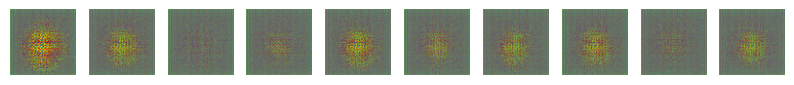

50 556.3593139648438 0.00018979999999999567


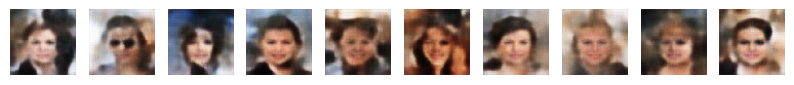

100 403.6632995605469 0.00017979999999999136


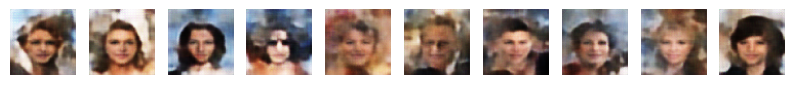

150 325.99005126953125 0.00016979999999998705


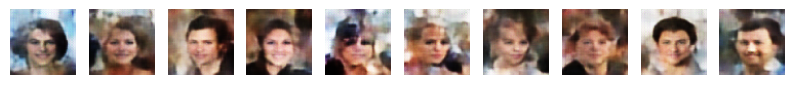

200 287.19384765625 0.00015979999999998274


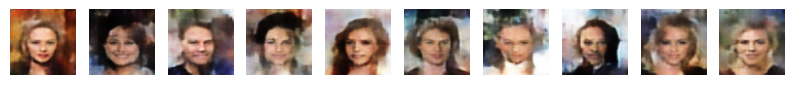

250 243.22702026367188 0.00014979999999997843


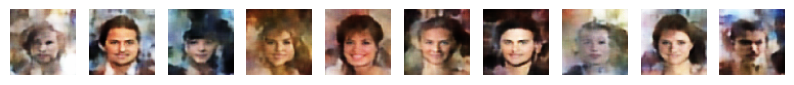

300 234.92063903808594 0.00013979999999997412


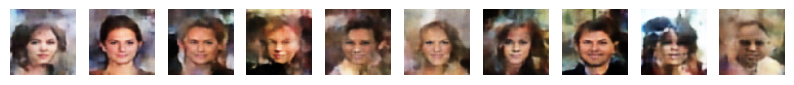

350 218.74012756347656 0.00012979999999996982


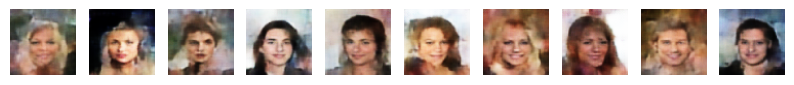

KeyboardInterrupt: 

In [9]:
def train():
    for epoch in range(1000):
        for _, data in enumerate(loader):
            data = data.to(device)

            pred, mu, log_var = vae(data)

            loss_mse = criterion(pred, data) * 10000
            loss_mse = loss_mse.mean(dim=(1, 2, 3))

            loss_kl = 1 + log_var - mu**2 - log_var.exp()
            loss_kl = loss_kl.sum(dim=1) * -0.5

            loss = (loss_mse + loss_kl).mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        if epoch % 50 == 0:
            print(epoch, loss.item(), optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                gen = decoder(torch.randn(10, 128, device=device))
            show(gen)


local_training = True

if local_training:
    train()